In [31]:
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [19]:
data = pd.read_csv("dataset/train.csv", index_col=[0])
test = pd.read_csv("dataset/test.csv", index_col=[0])

# convert the date field to datetime object
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
test['date'] = pd.to_datetime(test['date'], format='%d/%m/%Y %H:%M')

## Code for create date features

In [20]:
# Feature list
features = ['quarter', 'weekofyear', 'month', 'dayofweek', 'day', 'dayofyear', 'hour', 'is_holiday']

# Holiday list
# https://www.timeanddate.com/holidays/hong-kong/2017
# https://www.timeanddate.com/holidays/hong-kong/2018
holiday = pd.read_csv('holiday.csv').drop(columns=["Unnamed: 4", "Unnamed: 5", "Unnamed: 6"])
holiday['Date'] = pd.to_datetime(holiday['Date'], format='%Y %d %b')
hl = holiday['Date'].to_list()

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    # True if the date is in holiday list, else False
    df['is_holiday'] = np.where(df['date'].isin(hl), True, False)
    
    X = df[features]
    
    # If label exist, also return the label column as y
    if label:
        y = df[label]
        return X.to_numpy(), y
    return X.to_numpy()

# Testing set
test_x = create_features(test)

## Prepare Data

In [96]:
start = pd.to_datetime(datetime.datetime.strptime("1/1/2017", '%d/%m/%Y').date())
end = pd.to_datetime(datetime.datetime.strptime("1/1/2018", '%d/%m/%Y').date())
mask = (data['date'] >= start) & (data['date'] < end)
# Split way no.1 Train: 2017, Validation: 2018
train = data.loc[mask]
val = data.loc[~mask]

train_x, train_y = create_features(train, label='speed')
val_x, val_y = create_features(val, label='speed')

# Split way no.2 Random Split, with test size 0.2
data_X, y = create_features(data, label='speed')
X_train, X_test, y_train, y_test = train_test_split(data_X, y, test_size=0.15, random_state=42)

In [156]:
# xgb_model = xgb.XGBRegressor(objective="reg:squarederror", seed=42, n_estimators=1000, subsample=0.8)
# xgb_model = xgb.XGBRegressor(objective="reg:squarederror", seed=42, subsample=0.8)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", seed=42, subsample=0.8,
                             max_depth=8, learning_rate=0.075, gamma=0.25, n_estimators=1000)

# xgb_model = xgb.XGBRegressor(objective="reg:squarederror", seed=42, subsample=0.8,
#                              max_depth=8, learning_rate=0.075, gamma=0.25, n_estimators=1000,
#                              min_child_weight=20, colsample_bytree=0.8)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# test_x = np.array(test_x)
# y_pred = xgb_model.predict(val_x)

# mse=mean_squared_error(y_pred, val_y)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_pred, y_test)
mse

11.73952232119082

## GridSearchCV

In [134]:
# First set of the grid search parameters
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0]
# }

# Second set of the grid search parameters
# param_grid = {
#     'max_depth': [5,6,7,8,9,10],
#     'learning_rate': [0.05, 0.075, 0.025],
#     'gamma': [0.25]
# }

# Third set of the grid search parameters
param_grid = {
    'max_depth': [7,8,9],
    'learning_rate': [0.1, 0.075, 0.08, 0.09],
    'gamma': [0.25]
}

In [135]:
best_parameters = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", seed=42, subsample=0.8, n_estimators=1000),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=12,
    cv=3
)

In [136]:
best_parameters.fit(X_train, y_train, early_stopping_rounds=10,
                    eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
best_parameters.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  32 out of  36 | elapsed:    7.5s remaining:    0.9s
[Parallel(n_jobs=12)]: Done  36 out of  36 | elapsed:    7.8s finished


{'gamma': 0.25, 'learning_rate': 0.075, 'max_depth': 8}

## Error Analysis

In [6]:
def error_evaluation(input_, prediction, ground_truth):
    
    # Error by hour
    error_by_hour = dict()
    hour_index = 6
    for i in range(len(input_)):
        error = abs(prediction[i] - ground_truth[i]) ** 2
        try:
            error_by_hour[input_[i][hour_index]].append(error)
        except KeyError:
            error_by_hour[input_[i][hour_index]] = [error]
            
    for k, v in error_by_hour.items():
        error_by_hour[k] = np.array(v).mean()
    pd.DataFrame(error_by_hour, index=[0]).T.sort_index().plot(kind='bar')
    
    # Error by weekday
    error_by_weekday = dict()
    wd_index = 3
    for i in range(len(input_)):
        error = abs(prediction[i] - ground_truth[i]) ** 2
        try:
            error_by_weekday[input_[i][wd_index]].append(error)
        except KeyError:
            error_by_weekday[input_[i][wd_index]] = [error]
            
    for k, v in error_by_weekday.items():
        error_by_weekday[k] = np.array(v).mean()
    pd.DataFrame(error_by_weekday, index=[0]).T.sort_index().plot(kind='bar')
    
    # Error by month
    error_by_dm = dict()
    dm_index = 2
    for i in range(len(input_)):
        error = abs(prediction[i] - ground_truth[i]) ** 2
        try:
            error_by_dm[input_[i][dm_index]].append(error)
        except KeyError:
            error_by_dm[input_[i][dm_index]] = [error]
            
    for k, v in error_by_dm.items():
        error_by_dm[k] = np.array(v).mean()
    pd.DataFrame(error_by_dm, index=[0]).T.sort_index().plot(kind='bar')
    
    return error_by_weekday, error_by_hour, error_by_dm

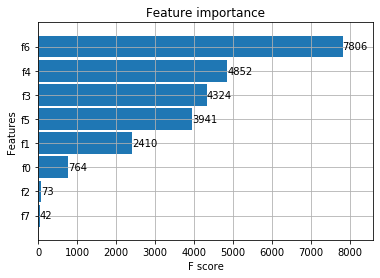

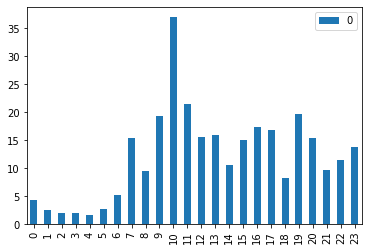

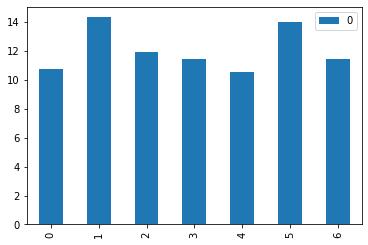

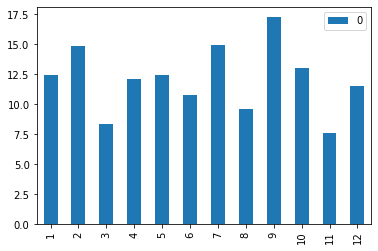

In [73]:
_ = plot_importance(xgb_model, height=0.9)
_ = error_evaluation(X_test, list(y_pred), list(y_test))

## Prediction on Testing data

In [139]:
test_y_pred = xgb_model.predict(test_x)
prediction_file_name = 'zwubq_8_20201205.csv'
pd.DataFrame(test_y_pred).rename({0: 'speed'}, axis=1).to_csv(prediction_file_name, index=True)
pd.read_csv(prediction_file_name, index_col=None).rename({'Unnamed: 0': 'id'}, axis=1).to_csv(prediction_file_name, index=False)